# Traveling Salesperson Problem: A Comparative Analysis of Simulated Annealing Algorithm and Genetic Algorithm

This Jupyter Notebook explores the Traveling Salesperson Problem (TSP) and compares the performance of two well-known optimization algorithms: Simulated Annealing (SA) and Genetic Algorithm (GA). The TSP aims to find the shortest possible route that visits a given set of cities exactly once and returns to the starting city. This 1  problem has numerous applications in logistics, planning, and transportation.

I will analyze the performance of Simulated Annealing (SA) and Genetic Algorithm (GA) on a dataset of cities, evaluating their efficiency, solution quality, and scalability. The analysis will include visualizations of the routes, performance comparisons, and convergence analysis.



In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import random
import time
import math


## Data Preparation and Visualization

The following code block loads the city data from a CSV file named `cities.csv`. It then extracts the city names and their corresponding coordinates. Finally, it calculates the Euclidean distance matrix, which stores the distances between all pairs of cities. This distance matrix is crucial for evaluating the length of different routes.

In [48]:
# Load data from the CSV file.
data = pd.read_csv('cities.csv')

# Extract city names and coordinates.
cities = data['City'].values
coordinates = data[['X', 'Y']].values

# Calculate the Euclidean distance matrix between all pairs of cities.
dist_matrix = cdist(coordinates, coordinates, 'euclidean') 


These functions help visualize the cities and the routes generated by the algorithms.

*  `visualize_raw_cities(cities_cord)`: This function creates a scatter plot to display the locations of the cities. This provides an initial overview of the spatial distribution of the cities.

*  `plot_route_with_labels(route, coordinates, city_names, title="Route")`: This function plots a given route on a graph, connecting the cities in the order they are visited. It also adds labels to the cities and arrows to indicate the direction of travel. This visualization helps in understanding the paths generated by the SA and GA algorithms.

In [49]:
def visualize_raw_cities(cities_cord):
    """
    Visualizes the raw city coordinates on a scatter plot.

    Args:
      cities_cord: A list of tuples, where each tuple represents the (x, y) 
                   coordinates of a city.
    """
    plt.figure(figsize=(10, 6))  # Creates a figure with a specific size
    
    # Plots a scatter plot of city coordinates.
    plt.scatter([city[0] for city in cities_cord], 
                [city[1] for city in cities_cord], 
                color='red')  
    
    plt.show()  # Displays the plot


def plot_route_with_labels(route, coordinates, city_names, title="Route"):
    """
    Plots a given route on a graph with city labels and arrows indicating 
    the direction of travel.

    Args:
      route: A list of integers representing the sequence of cities in the route.
      coordinates: A NumPy array of city coordinates.
      city_names: A list of city names corresponding to the coordinates.
      title: (Optional) The title of the plot. Defaults to "Route".
    """
    # Reorder coordinates and city names according to the route.
    route_coords = coordinates[route + [route[0]]]  # Add the starting city at the end for a closed loop
    route_names = [city_names[i] for i in route] + [city_names[route[0]]]

    plt.figure(figsize=(12, 8))

    # Plot the route with arrows.
    for i in range(len(route_coords) - 1):
        plt.plot(
            [route_coords[i][0], route_coords[i + 1][0]],
            [route_coords[i][1], route_coords[i + 1][1]],
            'o-', markersize=8, color='blue'
        )

        # Add an arrow to indicate direction.
        plt.arrow(
            route_coords[i][0], route_coords[i][1],
            route_coords[i + 1][0] - route_coords[i][0],
            route_coords[i + 1][1] - route_coords[i][1],
            head_width=0.5, head_length=0.5, fc='blue', ec='blue'
        )

        # Label the city with its name and sequence number.
        plt.text(
            route_coords[i][0], route_coords[i][1],
            f"{route_names[i]} ({i + 1})", color='black',
            fontsize=9, ha='center'
        )

    # Label the final city (which is also the starting city).
    plt.text(
        route_coords[-1][0], route_coords[-1][1],
        f"{route_names[-1]} (Start)", color='black',
        fontsize=9, ha='center'
    )

    # Add plot title, labels, and grid.
    plt.title(title)
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.grid()
    plt.show()

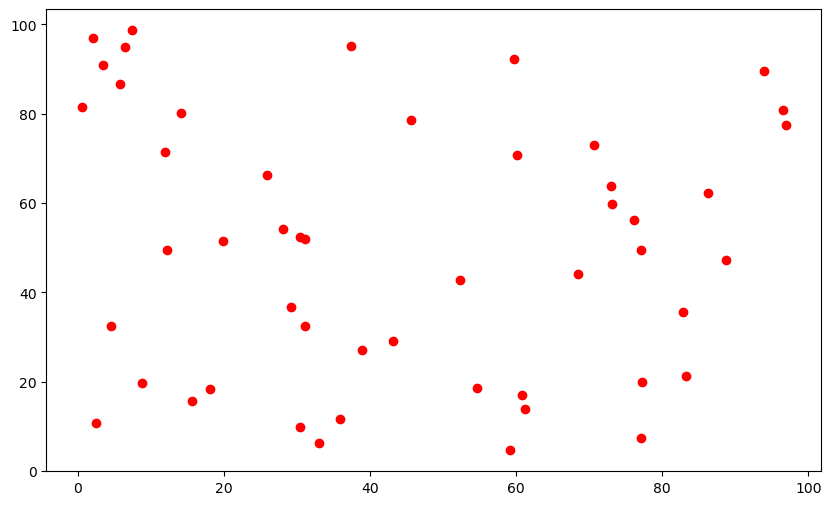

In [16]:
visualize_raw_cities(coordinates)

## Stage 1: Single-Solution-Driven Search Algorithm (Simulated Annealing)

Single-solution-driven search algorithms focus on iteratively improving a single candidate solution. They start with an initial solution and explore its neighborhood to find better solutions. One popular example of this approach is Simulated Annealing (SA).

<b>Simulated Annealing</b>

Simulated Annealing is a metaheuristic inspired by the annealing process in metallurgy, where a material is heated and then slowly cooled to reduce defects and improve its structure. 1  In the context of optimization, SA starts with an initial solution and iteratively explores neighboring solutions. It accepts better solutions and, with a certain probability, also accepts worse solutions to escape local optima. This probability is controlled by a temperature parameter that gradually decreases over time.

### SA Implementation

The following code defines the `SimulatedAnnealingTSP` class, which implements the SA algorithm for solving the TSP. It includes methods for calculating the total distance of a route, generating neighboring solutions, calculating the acceptance probability, and running the optimization process.

In [70]:
class SimulatedAnnealingTSP:
    """
    Solves the Traveling Salesperson Problem (TSP) using Simulated Annealing.

    Attributes:
        cities: A list of city names.
        dist_matrix: A NumPy array representing the distance matrix between cities.
        num_cities: The number of cities in the problem.
        initial_temp: The initial temperature for simulated annealing.
        cooling_rate: The rate at which the temperature cools down.
        min_temp: The minimum temperature at which the algorithm stops.
        best_route: The best route found so far.
        best_distance: The total distance of the best route.
        best_distance_history: A list to store the best distance at each iteration.

    Methods:
        _calculate_distance(route): Calculates the total distance of a given route.
        _generate_neighbor(current_route): Generates a neighboring route by swapping two cities.
        _acceptance_probability(old_cost, new_cost, temperature): 
                                    Calculates the acceptance probability of a new route.
        optimize(): Runs the simulated annealing optimization algorithm.
    """
    def __init__(self, cities, dist_matrix, initial_temp=1000, cooling_rate=0.003, min_temp=0.1):
        """
        Initializes the SimulatedAnnealingTSP object.

        Args:
            cities: A list of city names.
            dist_matrix: A NumPy array representing the distance matrix.
            initial_temp: The initial temperature.
            cooling_rate: The cooling rate.
            min_temp: The minimum temperature.
        """
        self.cities = cities
        self.dist_matrix = dist_matrix
        self.num_cities = len(cities)
        self.initial_temp = initial_temp
        self.cooling_rate = cooling_rate
        self.min_temp = min_temp
        self.best_route = None
        self.best_distance = float('inf')  # Initialize best distance to infinity
        self.best_distance_history = []

    def _calculate_distance(self, route):
        """
        Calculates the total distance of a given route.

        Args:
            route: A list representing the order of cities visited.

        Returns:
            The total distance of the route.
        """
        total_distance = 0
        for i in range(self.num_cities):
            # Calculate the distance between the current city and the next city in the route
            # Using the modulo operator (%) to wrap around to the beginning of the route for the last city
            current_city = route[i]
            next_city = route[(i + 1) % self.num_cities] 
            distance = self.dist_matrix[current_city][next_city]
            total_distance += distance
        return total_distance

    def _generate_neighbor(self, current_route):
        """
        Generates a neighboring route by randomly swapping two cities.

        Args:
            current_route: The current route.

        Returns:
            A new route with two cities swapped.
        """
        new_route = current_route[:]  # Create a copy of the current route to avoid modifying it directly
        i, j = random.sample(range(self.num_cities), 2)  # Select two distinct random city indices
        new_route[i], new_route[j] = new_route[j], new_route[i]  # Swap the cities at the chosen indices
        return new_route

    def _acceptance_probability(self, old_cost, new_cost, temperature):
        """
        Calculates the acceptance probability of a new route based on 
        the Metropolis criterion.

        Args:
            old_cost: The cost (distance) of the current route.
            new_cost: The cost (distance) of the new route.
            temperature: The current temperature.

        Returns:
            The probability of accepting the new route.
        """
        if new_cost < old_cost:
            return 1.0  # Always accept if the new route is better
        # Otherwise, calculate the acceptance probability based on the temperature and the difference in cost
        return math.exp((old_cost - new_cost) / temperature)  

    def optimize(self, seed=10):
        """
        Runs the simulated annealing optimization to find the best route.

        Returns:
            A tuple containing:
                - The best route found.
                - The total distance of the best route.
                - A list of best distances at each iteration.
        """
        # Set random seed for replicability
        np.random.seed(seed)
        random.seed(seed)
        
        current_route = list(range(self.num_cities))  # Generate an initial route (e.g., [0, 1, 2, ...])
        random.shuffle(current_route)  # Randomize the initial route
        current_distance = self._calculate_distance(current_route)  # Calculate the distance of the initial route

        self.best_route = current_route[:]  # Store the initial route as the best route
        self.best_distance = current_distance  # Store the initial distance as the best distance

        temperature = self.initial_temp  # Set the initial temperature

        while temperature > self.min_temp:  # Continue until the temperature cools down to the minimum
            neighbor = self._generate_neighbor(current_route)  # Generate a neighboring route
            neighbor_distance = self._calculate_distance(neighbor)  # Calculate the distance of the neighbor

            # Decide whether to accept the neighbor based on the acceptance probability
            if self._acceptance_probability(current_distance, neighbor_distance, temperature) > random.random():  
                current_route = neighbor[:]  # Accept the neighbor as the current route
                current_distance = neighbor_distance  

            if current_distance < self.best_distance:  # Update the best route if the current route is better
                self.best_route = current_route[:]
                self.best_distance = current_distance
            
            self.best_distance_history.append(self.best_distance)  # Record the best distance at this iteration
            temperature *= (1 - self.cooling_rate)  # Cool down the temperature

        return self.best_route, self.best_distance, self.best_distance_history  # Return the best route, distance, and history
    
    def save_results(self, filename):
        """
        Saves the best route and the best distance to a text file.

        Args:
            filename: The name of the file to save the results.
        """
        with open(filename, 'w') as file:
            file.write(f"Best Route: {self.best_route}\n")
            file.write(f"Best Distance: {self.best_distance}\n")

### Simulated Annealing Hyper-Parameter Tuning

The `SA_HyperparameterTuner` class facilitates the tuning of hyperparameters for the Simulated Annealing algorithm. Hyperparameters such as initial temperature (`initial_temp`), cooling rate (`cooling_rate`), and minimum temperature (`min_temp`) can significantly influence the performance of the algorithm. This class performs a grid search over a defined hyperparameter space to identify the combination that yields the best results.

In [71]:
class SA_HyperparameterTuner:
    """
    Perform hyperparameter optimization for the Simulated Annealing TSP solver.

    Attributes:
        cities (list): List of city names.
        dist_matrix (np.ndarray): Distance matrix between cities.
        parameter_grid (dict): Grid of hyperparameters to search.
    """

    def __init__(self, cities, dist_matrix, parameter_grid):
        """
        Initialize the hyperparameter tuner.

        Args:
            cities (list): List of city names.
            dist_matrix (np.ndarray): Distance matrix between cities.
            parameter_grid (dict): Grid of hyperparameters to search.
        """
        self.cities = cities
        self.dist_matrix = dist_matrix
        self.parameter_grid = parameter_grid

    def _evaluate_hyperparameters(self, initial_temp, cooling_rate, min_temp):
        """
        Evaluate the performance of a specific hyperparameter combination.

        Args:
            initial_temp (float): Initial temperature for simulated annealing.
            cooling_rate (float): Cooling rate for temperature reduction.
            min_temp (float): Minimum temperature threshold.

        Returns:
            dict: Performance metrics for the current hyperparameter combination.
        """
        tsp_solver = SimulatedAnnealingTSP(
            self.cities, self.dist_matrix,
            initial_temp=initial_temp,
            cooling_rate=cooling_rate,
            min_temp=min_temp
        )
        start_time = time.time()  # Record start time
        best_route, best_distance, _ = tsp_solver.optimize(seed=10)  # Run the optimization
        elapsed_time = time.time() - start_time  # Calculate elapsed time

        # Return performance metrics
        return {
            "Initial Temp": initial_temp,
            "Cooling Rate": cooling_rate,
            "Min Temp": min_temp,
            "Best Distance": best_distance,
            "Time (s)": elapsed_time
        }

    def grid_search(self):
        """
        Perform grid search over the hyperparameter space.

        Returns:
            list: Results for all hyperparameter combinations.
        """
        results = []
        # Iterate through all combinations of hyperparameters
        for initial_temp in self.parameter_grid["initial_temp"]:
            for cooling_rate in self.parameter_grid["cooling_rate"]:
                for min_temp in self.parameter_grid["min_temp"]:
                    try:
                        # Evaluate the current hyperparameter combination
                        performance = self._evaluate_hyperparameters(initial_temp, cooling_rate, min_temp)
                        results.append(performance)
                        print(f"Evaluated: {performance}")  # Print the results for this combination
                    except Exception as e:
                        print(f"Error with parameters {initial_temp}, {cooling_rate}, {min_temp}: {e}")
        return results
    

# --- Testing Hyperparameter Optimization ---

# Load data (assuming this is how you load your data)
data = pd.read_csv('cities.csv') 
cities = data['City'].values
coordinates = data[['X', 'Y']].values
dist_matrix = cdist(coordinates, coordinates, 'euclidean')

# Define the hyperparameter grid to search
parameter_grid = {
    "initial_temp": [500, 1000, 1500],
    "cooling_rate": [0.001, 0.003, 0.005],
    "min_temp": [0.1, 0.5, 1.0]
}

# Create a hyperparameter tuner instance and run the grid search
sa_tuner = SA_HyperparameterTuner(cities, dist_matrix, parameter_grid)
sa_hyperparameter_results = sa_tuner.grid_search()

# Sort the results by best distance (ascending)
sa_hyperparameter_results.sort(key=lambda x: x["Best Distance"])

# Display the top 3 configurations
print("\nTop 3 Hyperparameter Configurations:")
for result in sa_hyperparameter_results[:3]:
    print(result)



Evaluated: {'Initial Temp': 500, 'Cooling Rate': 0.001, 'Min Temp': 0.1, 'Best Distance': 823.4601929418278, 'Time (s)': 0.13412213325500488}
Evaluated: {'Initial Temp': 500, 'Cooling Rate': 0.001, 'Min Temp': 0.5, 'Best Distance': 897.6975076628842, 'Time (s)': 0.10860300064086914}
Evaluated: {'Initial Temp': 500, 'Cooling Rate': 0.001, 'Min Temp': 1.0, 'Best Distance': 949.2375488291015, 'Time (s)': 0.09708929061889648}
Evaluated: {'Initial Temp': 500, 'Cooling Rate': 0.003, 'Min Temp': 0.1, 'Best Distance': 903.2180438720364, 'Time (s)': 0.04403972625732422}
Evaluated: {'Initial Temp': 500, 'Cooling Rate': 0.003, 'Min Temp': 0.5, 'Best Distance': 1003.4368432471477, 'Time (s)': 0.03603219985961914}
Evaluated: {'Initial Temp': 500, 'Cooling Rate': 0.003, 'Min Temp': 1.0, 'Best Distance': 1015.9279650638792, 'Time (s)': 0.03303074836730957}
Evaluated: {'Initial Temp': 500, 'Cooling Rate': 0.005, 'Min Temp': 0.1, 'Best Distance': 1018.6812589006347, 'Time (s)': 0.027024507522583008}
Ev

### Run SA Algorithm with Optimized Hyperparameters

This code block utilizes the results from the hyperparameter tuning to run the Simulated Annealing algorithm with the best-performing parameters. It extracts the optimal hyperparameter values, creates an instance of the `SimulatedAnnealingTSP` solver with these values, and then executes the optimization. Finally, it prints the best distance achieved and visualizes the corresponding route.

Best Distance: 814.0286964901217


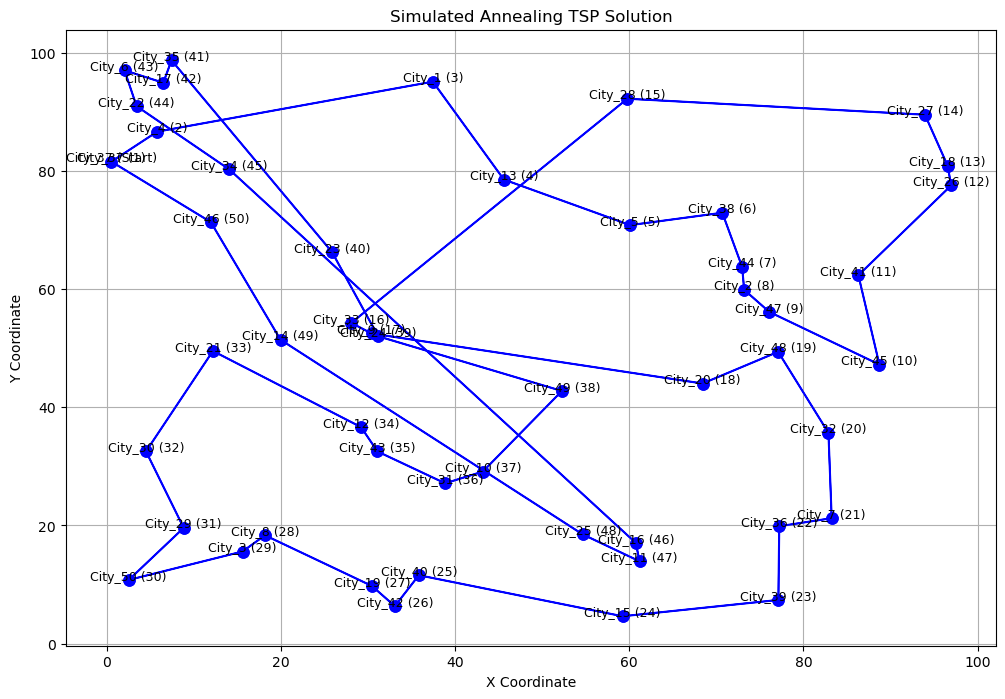

In [74]:
# Get the best hyperparameters from the tuning results
initial_temp = sa_hyperparameter_results[0]['Initial Temp']
cooling_rate = sa_hyperparameter_results[0]['Cooling Rate']
min_temp = sa_hyperparameter_results[0]['Min Temp']

# Create a SimulatedAnnealingTSP solver with the best hyperparameters
sa_tsp_solver = SimulatedAnnealingTSP(cities, dist_matrix, 
                                     initial_temp=initial_temp, 
                                     cooling_rate=cooling_rate, 
                                     min_temp=min_temp)

# Run the optimization with the tuned hyperparameters
sa_best_route, sa_best_distance, sa_covergance = sa_tsp_solver.optimize()
sa_tsp_solver.save_results("sa_tsp_results.txt") 

# Print the best distance found
print(f"Best Distance: {sa_best_distance}")

# Visualize the solution
plot_route_with_labels(sa_best_route, coordinates, cities, title="Simulated Annealing TSP Solution")

## Stage 2: Evolution Driven-Search Algorithm (Genetic Algorithm)

Evolution-driven search algorithms, inspired by the process of natural selection, maintain a population of candidate solutions and iteratively evolve them towards better solutions. Genetic Algorithms (GA) are a prime example of this approach.

<b>Genetic Algorithm</b>

Genetic Algorithms operate on a population of individuals, each representing a potential solution. These individuals are encoded as "chromosomes" (often lists or arrays). The algorithm iteratively applies genetic operators like selection, crossover, and mutation to evolve the population. 

*   **Selection:**  Favors individuals with better fitness (e.g., shorter route distances in the TSP) to be parents for the next generation.
*   **Crossover:** Combines genetic material from two parents to create offspring.
*   **Mutation:** Introduces small random changes in the offspring to maintain diversity.

Through these operations, GAs explore the solution space and progressively converge towards optimal or near-optimal solutions.

### GA Implementaion

The `GeneticAlgorithmTSP` class implements the GA for solving the TSP. It includes methods for initializing a population, performing tournament selection, applying two-point crossover, introducing inverse mutation, and running the optimization process.

In [77]:
class GeneticAlgorithmTSP:
    """
    Solves the Traveling Salesperson Problem (TSP) using a Genetic Algorithm.
    """

    def __init__(self, cities, dist_matrix, population_size=100, mutation_rate=0.1, generations=500, seed=None):
        """
        Initializes the GeneticAlgorithmTSP object.

        Args:
            cities: A list of city names.
            dist_matrix: A NumPy array representing the distance matrix.
            population_size: The size of the population.
            mutation_rate: The mutation rate.
            generations: The number of generations.
            seed: A seed for random number generation (default is None).
        """
        self.cities = cities
        self.dist_matrix = dist_matrix
        self.num_cities = len(cities)
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.generations = generations
        self.best_route = None
        self.best_distance = float('inf')  # Initialize best distance to infinity
        self.best_distance_history = []
        
        if seed is not None:
            np.random.seed(seed)
            random.seed(seed)

    def _calculate_distance(self, route):
        """
        Calculates the total distance of a given route.
        """
        total_distance = 0
        for i in range(self.num_cities):
            current_city = route[i]
            next_city = route[(i + 1) % self.num_cities]  # Wrap around for the last city
            distance = self.dist_matrix[current_city][next_city]
            total_distance += distance
        return total_distance

    def _initialize_population(self):
        """
        Creates an initial population of random routes.
        """
        population = []
        for _ in range(self.population_size):
            route = random.sample(range(self.num_cities), self.num_cities)  # Generate random route
            population.append(route)
        return population

    def _tournament_selection(self, population, scores):
        """
        Selects parents using tournament selection.
        """
        tournament = random.sample(list(zip(population, scores)), k=5)  # Tournament size 5
        return min(tournament, key=lambda x: x[1])[0]  # Return the individual with the shortest distance

    def _two_point_crossover(self, parent1, parent2):
        """
        Perform 2-point crossover between two parents.
        """
        start, end = sorted(random.sample(range(self.num_cities), 2))  # Select two random crossover points
        child = [-1] * self.num_cities  # Initialize the child with placeholders
        child[start:end] = parent1[start:end]  # Copy the segment between crossover points from parent1

        pointer = 0
        for gene in parent2:
            if gene not in child:  # If the gene is not already in the child
                while child[pointer] != -1:  # Find the next available position in the child
                    pointer += 1
                child[pointer] = gene  # Insert the gene into the child
        return child

    def _inverse_mutation(self, route):
        """
        Perform inverse mutation by reversing a sub-segment of the route.
        """
        if random.random() < self.mutation_rate:  # Apply mutation with a probability of mutation_rate
            start, end = sorted(random.sample(range(self.num_cities), 2))  # Select two random points
            route[start:end] = reversed(route[start:end])  # Reverse the segment between the points

    def optimize(self, seed=None):
        """
        Runs the genetic algorithm optimization to find the best route.
        """
        if seed is not None:
            np.random.seed(seed)
            random.seed(seed)

        population = self._initialize_population()  # Create the initial population

        for generation in range(self.generations):  # Iterate through generations
            scores = [self._calculate_distance(individual) for individual in population]  # Calculate distances
            next_generation = []  # Initialize the next generation

            for _ in range(self.population_size // 2):  # Create new individuals for the next generation
                parent1 = self._tournament_selection(population, scores)  # Select parents using tournament selection
                parent2 = self._tournament_selection(population, scores)
                child1 = self._two_point_crossover(parent1, parent2)  # Create children using crossover
                child2 = self._two_point_crossover(parent2, parent1)
                self._inverse_mutation(child1)  # Apply mutation to children
                self._inverse_mutation(child2)
                next_generation.extend([child1, child2])  # Add children to the next generation

            population = next_generation  # Replace the old population with the new generation

            # Update the best route if a better route is found
            best_idx = np.argmin(scores)  # Find the index of the best route in the current generation
            if scores[best_idx] < self.best_distance:  # Update the best route if a better route is found
                self.best_distance = scores[best_idx]
                self.best_route = population[best_idx]
            
            self.best_distance_history.append(self.best_distance)  # Record the best distance for this generation

        return self.best_route, self.best_distance, self.best_distance_history  # Return the results

    def save_results(self, filename):
            """
            Saves the best route and the best distance to a text file.
    
            Args:
                filename: The name of the file to save the results.
            """
            with open(filename, 'w') as file:
                file.write(f"Best Route: {self.best_route}\n")
                file.write(f"Best Distance: {self.best_distance}\n")

### Run GA Algorithm

This code block creates an instance of the `GeneticAlgorithmTSP` solver with specified parameters (population size, mutation rate, and number of generations). It then runs the optimization process and retrieves the best route found, its distance, and the convergence history. Finally, it prints the best distance and visualizes the optimal route using the `plot_route_with_labels` function.

Best Distance: 830.8191414610451


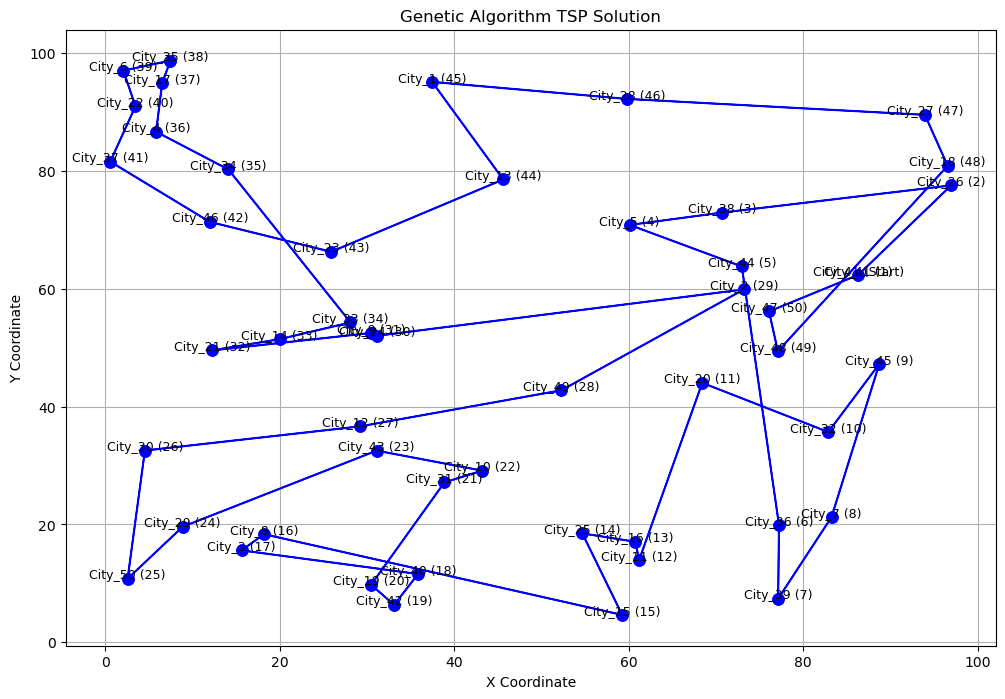

In [78]:
# Create a GeneticAlgorithmTSP solver with specified parameters
ga_tsp_solver = GeneticAlgorithmTSP(cities, dist_matrix, 
                                   population_size=50, 
                                   mutation_rate=0.05, 
                                   generations=300)

# Run the optimization 
ga_best_tour, ga_best_distance, ga_convergance = ga_tsp_solver.optimize(seed=10)

# Print the best distance found
print(f"Best Distance: {ga_best_distance}")
ga_tsp_solver.save_results("ga_tsp_results.txt") 

# Visualize the solution
plot_route_with_labels(ga_best_tour, coordinates, cities, title="Genetic Algorithm TSP Solution")

# Performance Comparision

This section compares the performance of Simulated Annealing (SA) and the Genetic Algorithm (GA) based on their solutions to the TSP.

### Side by Side Visualization of Routes

The `plot_routes_with_labels` function helps visualize and compare the routes generated by the SA and GA algorithms. It plots both routes on the same graph with different colors, allowing for a direct visual comparison of their paths and efficiencies. 

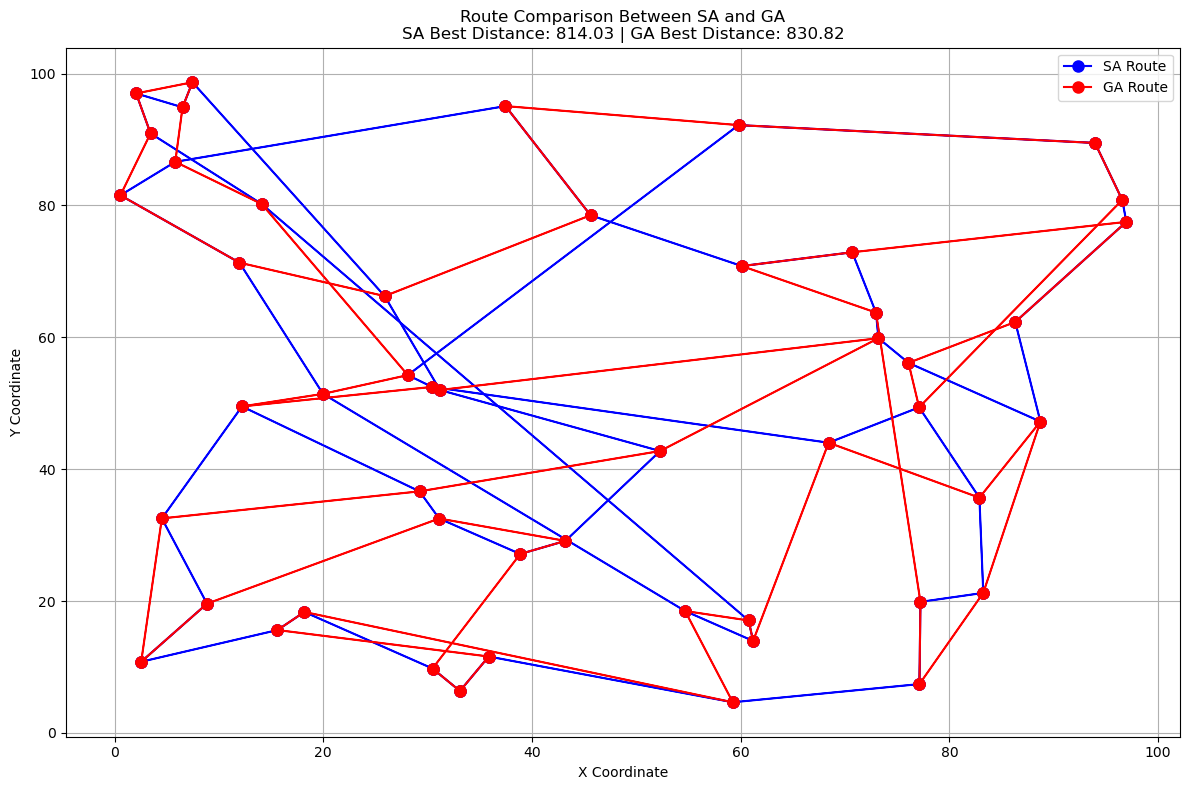

In [79]:
def plot_routes_with_labels(sa_route, ga_route, coordinates, sa_best_distance, ga_best_distance, title="Routes Comparison"):
    """
    Plots two routes (e.g., from Simulated Annealing and Genetic Algorithm) on a graph 
    with arrows indicating the direction of travel.

    Args:
        sa_route: A list of integers representing the sequence of cities in the SA route.
        ga_route: A list of integers representing the sequence of cities in the GA route.
        coordinates: A NumPy array of city coordinates.
        sa_best_distance: The best distance found by the Simulated Annealing algorithm.
        ga_best_distance: The best distance found by the Genetic Algorithm.
        title: (Optional) The title of the plot. Defaults to "Routes Comparison".
    """

    # Reorder coordinates according to the routes and add the starting city for a closed loop
    sa_route_coords = coordinates[sa_route + [sa_route[0]]]  
    ga_route_coords = coordinates[ga_route + [ga_route[0]]]
    
    plt.figure(figsize=(12, 8))

    # --- Plot the SA route ---
    for i in range(len(sa_route_coords) - 1):
        # Plot the line connecting cities
        plt.plot([sa_route_coords[i][0], sa_route_coords[i + 1][0]], 
                 [sa_route_coords[i][1], sa_route_coords[i + 1][1]], 
                 'o-', markersize=8, color='blue', label="SA Route" if i == 0 else "")
        
        # Add an arrow to indicate direction
        plt.arrow(sa_route_coords[i][0], sa_route_coords[i][1], 
                 sa_route_coords[i + 1][0] - sa_route_coords[i][0], 
                 sa_route_coords[i + 1][1] - sa_route_coords[i][1], 
                 head_width=0.5, head_length=0.5, fc='blue', ec='blue')

    # --- Plot the GA route ---
    for i in range(len(ga_route_coords) - 1):
        # Plot the line connecting cities
        plt.plot([ga_route_coords[i][0], ga_route_coords[i + 1][0]], 
                 [ga_route_coords[i][1], ga_route_coords[i + 1][1]], 
                 'o-', markersize=8, color='red', label="GA Route" if i == 0 else "")
        
        # Add an arrow to indicate direction
        plt.arrow(ga_route_coords[i][0], ga_route_coords[i][1], 
                 ga_route_coords[i + 1][0] - ga_route_coords[i][0], 
                 ga_route_coords[i + 1][1] - ga_route_coords[i][1], 
                 head_width=0.5, head_length=0.5, fc='red', ec='red')

    # Add plot title, labels, and grid
    plt.title(f"{title}\nSA Best Distance: {sa_best_distance:.2f} | GA Best Distance: {ga_best_distance:.2f}")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.grid()

    # Display the legend
    plt.legend()

    plt.tight_layout()  # Adjust layout to prevent labels from overlapping
    plt.show()


# Example usage:
plot_routes_with_labels(sa_best_route, ga_best_tour, coordinates, sa_best_distance, ga_best_distance, 
                       title="Route Comparison Between SA and GA")


**Insights from the Visualization:**

*   The routes generated by SA and GA are quite distinct, showcasing different approaches to traversing the cities. While they share some common edges, their overall paths differ significantly.
*   The SA route appears to be slightly more efficient in certain areas, forming shorter connections between clusters of cities, particularly in the lower left quadrant of the plot. 
*   The GA route, on the other hand, seems to prioritize a more consistent flow across the map, potentially leading to longer overall distances but possibly a more balanced distribution of travel.
   

### Average Computation Time and Best Distance

The following code defines functions to evaluate the performance of the algorithms and visualize the results.

*   `evaluate_algorithm(algorithm_func, runs=5)`: This function evaluates the performance of a given TSP algorithm by running it multiple times and calculating metrics like the best distance, average distance, standard deviation of distances, and average execution time.

*   `performance_test(dist_matrix, problem_sizes, algorithms)`: This function performs tests for the given TSP algorithms across different problem sizes, allowing us to analyze how the algorithms scale with the number of cities.

*   `plot_results(results)`: This function generates plots to visualize the performance metrics (average time and average distance) against the problem size. These visualizations help in understanding the computational efficiency and solution quality of the algorithms as the problem size increases.



SimulatedAnnealingTSP - Problem Size: 10, Best Distance: 290.31, Average Distance: 290.31, Standard Deviation: 0.00, Average Time: 0.02s
GeneticAlgorithmTSP - Problem Size: 10, Best Distance: 290.31, Average Distance: 290.31, Standard Deviation: 0.00, Average Time: 0.69s
SimulatedAnnealingTSP - Problem Size: 20, Best Distance: 386.63, Average Distance: 439.89, Standard Deviation: 31.49, Average Time: 0.02s
GeneticAlgorithmTSP - Problem Size: 20, Best Distance: 386.43, Average Distance: 398.17, Standard Deviation: 23.48, Average Time: 0.96s
SimulatedAnnealingTSP - Problem Size: 30, Best Distance: 563.07, Average Distance: 610.59, Standard Deviation: 40.78, Average Time: 0.03s
GeneticAlgorithmTSP - Problem Size: 30, Best Distance: 451.77, Average Distance: 460.37, Standard Deviation: 10.54, Average Time: 1.33s
SimulatedAnnealingTSP - Problem Size: 40, Best Distance: 668.07, Average Distance: 766.68, Standard Deviation: 63.40, Average Time: 0.04s
GeneticAlgorithmTSP - Problem Size: 40, Be

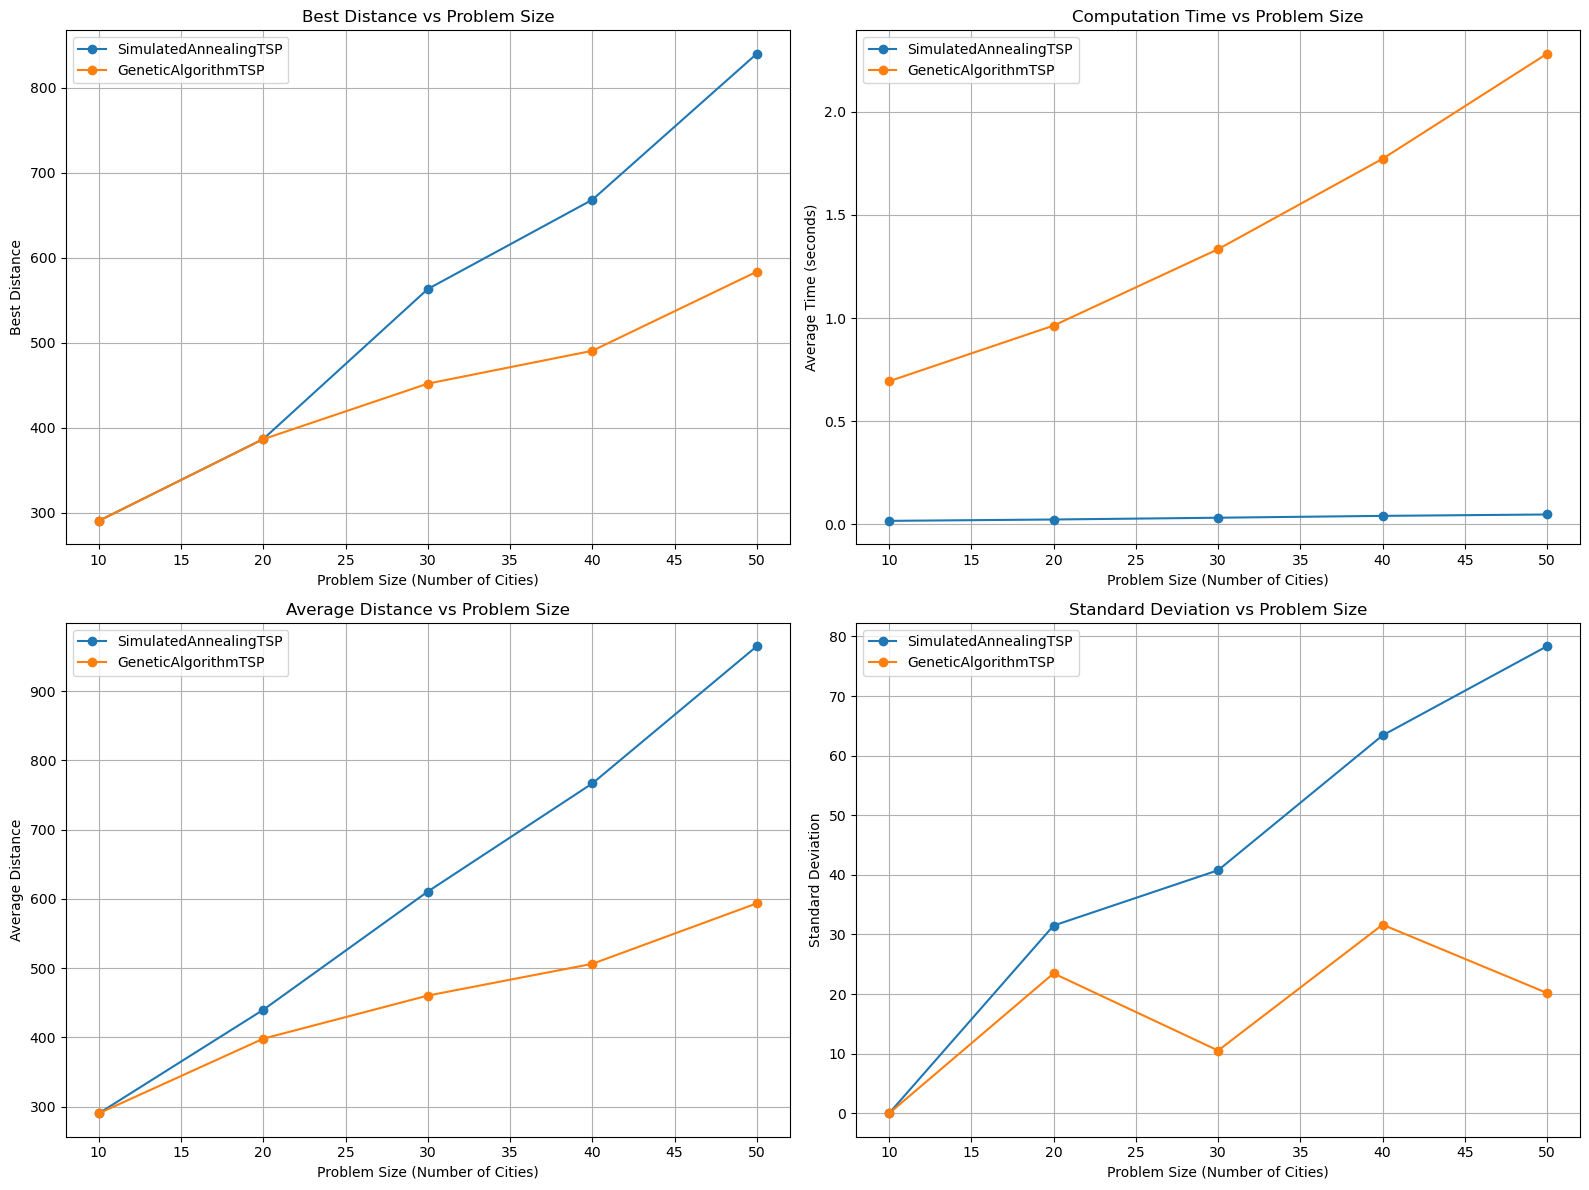

In [84]:
# Function to evaluate algorithm performance over multiple runs
def evaluate_algorithm(algorithm_func, runs=5,  random_seed=10):
    """
    Evaluates the performance of a given TSP algorithm over multiple runs.

    Args:
        algorithm_func: A function that runs the TSP algorithm and returns 
                        the best route, best distance, and convergence history.
        runs (int): The number of times to run the algorithm. Defaults to 5.

    Returns:
        dict: A dictionary containing performance metrics: best distance, average distance, 
              standard deviation of distances, and average execution time.
    """
    distances = []
    times = []

    for run in range(runs):
        np.random.seed(random_seed + run)  
        random.seed(random_seed + run) 
        
        # Create a new instance of the algorithm with random initialization
        start_time = time.time()
        _, best_distance, _ = algorithm_func(seed=random_seed + run)  # Pass random seed if needed
        end_time = time.time()
        
        distances.append(best_distance)
        times.append(end_time - start_time)

    return {
        'Best Distance': min(distances),
        'Average Distance': np.mean(distances),
        'Standard Deviation': np.std(distances),
        'Average Time': np.mean(times),
        'All Distances': distances,
    }

# Function to perform performance tests across varying problem sizes
def performance_test(dist_matrix, problem_sizes, algorithms):
    """
    Performs performance tests for the given TSP algorithms across different problem sizes.

    Args:
        dist_matrix (np.ndarray): The distance matrix between cities.
        problem_sizes (list): A list of problem sizes (number of cities) to test.
        algorithms (list): A list of TSP algorithm classes to evaluate.

    Returns:
        dict: A dictionary containing the performance results for each algorithm 
              at each problem size.
    """
    results = {alg.__name__: {} for alg in algorithms}  # Initialize a dictionary to store results
    
    for size in problem_sizes:  # Iterate over different problem sizes
        for algorithm in algorithms:  # Iterate over the algorithms
            # Create a TSP solver instance with the current problem size
            tsp_solver = algorithm(cities[:size], dist_matrix[:size, :size])  
            evaluation_result = evaluate_algorithm(tsp_solver.optimize)  # Evaluate the algorithm
            results[algorithm.__name__][size] = evaluation_result  # Store the results
            # Print the results for the current algorithm and problem size
            print(f"{algorithm.__name__} - Problem Size: {size}, "
                  f"Best Distance: {evaluation_result['Best Distance']:.2f}, "
                  f"Average Distance: {evaluation_result['Average Distance']:.2f}, "
                  f"Standard Deviation: {evaluation_result['Standard Deviation']:.2f}, "
                  f"Average Time: {evaluation_result['Average Time']:.2f}s")

    return results

# Function to plot the performance metrics
def plot_results(results):
    """
    Plots the performance metrics (best distance, average time, average distance, and standard deviation) 
    against problem size.

    Args:
        results (dict): A dictionary containing the performance results.
    """
    plt.figure(figsize=(16, 12))

    for alg_name, result in results.items():
        sizes = list(result.keys())
        best_distances = [result[size]['Best Distance'] for size in sizes]
        avg_times = [result[size]['Average Time'] for size in sizes]
        avg_distances = [result[size]['Average Distance'] for size in sizes]
        std_devs = [result[size]['Standard Deviation'] for size in sizes]

        # --- Plotting Best Distance ---
        plt.subplot(2, 2, 1)
        plt.plot(sizes, best_distances, marker='o', label=f"{alg_name}")
        plt.title("Best Distance vs Problem Size")
        plt.xlabel("Problem Size (Number of Cities)")
        plt.ylabel("Best Distance")
        plt.grid(True)

        # --- Plotting Average Time ---
        plt.subplot(2, 2, 2)
        plt.plot(sizes, avg_times, marker='o', label=f"{alg_name}")
        plt.title("Computation Time vs Problem Size")
        plt.xlabel("Problem Size (Number of Cities)")
        plt.ylabel("Average Time (seconds)")
        plt.grid(True)

        # --- Plotting Average Distance ---
        plt.subplot(2, 2, 3)
        plt.plot(sizes, avg_distances, marker='o', label=f"{alg_name}")
        plt.title("Average Distance vs Problem Size")
        plt.xlabel("Problem Size (Number of Cities)")
        plt.ylabel("Average Distance")
        plt.grid(True)

        # --- Plotting Standard Deviation ---
        plt.subplot(2, 2, 4)
        plt.plot(sizes, std_devs, marker='o', label=f"{alg_name}")
        plt.title("Standard Deviation vs Problem Size")
        plt.xlabel("Problem Size (Number of Cities)")
        plt.ylabel("Standard Deviation")
        plt.grid(True)

    # Add legends to each subplot
    for i in range(1, 5):
        plt.subplot(2, 2, i)
        plt.legend()

    plt.tight_layout()  # Adjust layout to prevent overlapping elements
    plt.show()



# --- Performance Testing ---
problem_sizes = [10, 20, 30, 40, 50]  # Define the problem sizes to test
algorithms = [SimulatedAnnealingTSP, GeneticAlgorithmTSP]  # Algorithms to compare
results = performance_test(dist_matrix, problem_sizes, algorithms)  # Run the performance tests

# --- Plot the results ---
plot_results(results)
   


**Insights from the Visualizations:**

*   **Computation Time:** As the number of cities increases, the computation time for both SA and GA increases. However, the rate of increase is much steeper for the GA. This suggests that SA is more computationally efficient, especially for larger problem instances.

*   **Average Distance:** The average distance of the solutions found by both algorithms also increases with the problem size. Interestingly, GA consistently finds solutions with shorter average distances compared to SA, indicating that GA might be better at finding good quality solutions, even though it takes more time.


*   **Standard Deviation:** The standard deviation of distances for SA tends to be higher than that of GA, especially for larger problem sizes. This suggests that SA's performance might be more variable across different runs compared to GA.

### Convergance of Simulated Annealing (SA) vs Genetic Algorithm (GA)

This plot illustrates the convergence trends of Simulated Annealing (SA) and the Genetic Algorithm (GA) over the iterations/generations. It shows how the best distance found by each algorithm changes as they explore the solution space.


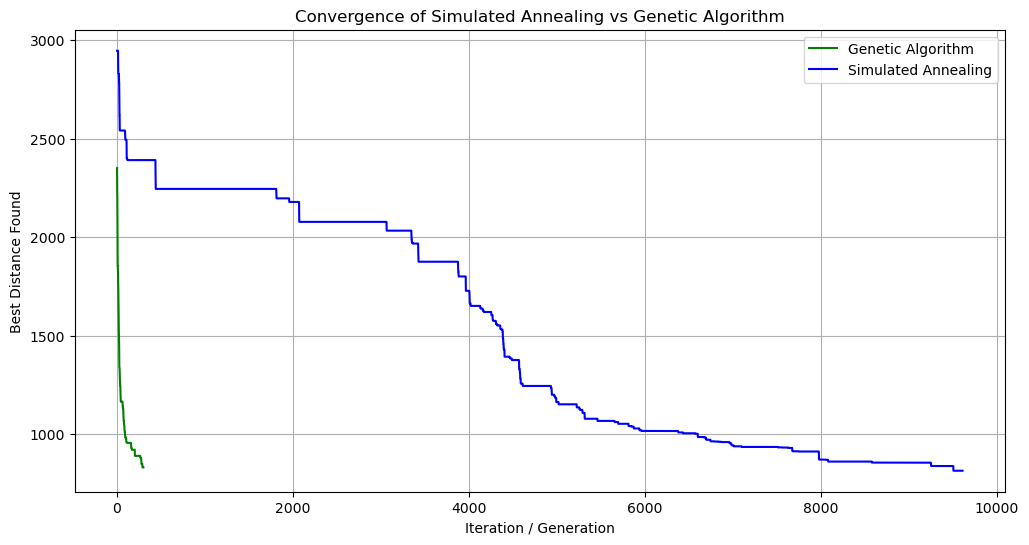

In [102]:
# Plot convergence trends
plt.figure(figsize=(12, 6))

# Plot the convergence curves for both algorithms
plt.plot(ga_convergance, label="Genetic Algorithm", color='green')  
plt.plot(sa_covergance, label="Simulated Annealing", color='blue')

# Add labels and title
plt.xlabel("Iteration / Generation")
plt.ylabel("Best Distance Found")
plt.title("Convergence of Simulated Annealing vs Genetic Algorithm")

plt.legend()  # Show the legend
plt.grid(True)  # Add a grid for better readability
plt.show()

**Insights from the Visualization:**

*   **Initial Stages:**  The GA exhibits a rapid improvement in solution quality in the initial generations, quickly finding a relatively good solution. SA, on the other hand, starts with a higher initial distance and gradually improves.

*   **Overall Trend:** Both algorithms demonstrate a general trend of decreasing distance over time, indicating that they are effectively searching for better solutions.

*   **Convergence Speed:** The GA appears to converge faster, reaching a plateau in solution quality earlier than SA. SA continues to make smaller improvements over a longer period.

*   **Exploration vs Exploitation:** The GA's early convergence might suggest a stronger focus on exploitation (refining existing solutions), while SA's gradual improvement could indicate a more balanced approach between exploration (searching new areas of the solution space) and exploitation.

**Analysis:**

The convergence plot highlights the different search strategies employed by SA and GA. The GA's rapid initial improvement and faster convergence can be attributed to its population-based approach, which allows it to explore multiple solutions simultaneously and effectively combine good traits through crossover. SA, with its focus on iteratively refining a single solution, explores the solution space more gradually and might be able to escape local optima more effectively due to its probabilistic acceptance of worse solutions.

# References
Adewole, A.P., Otubamowo, K. and Egunjobi, T.O. (2013) 'A Comparative Study of Simulated Annealing and Genetic Algorithm for Solving the Travelling Salesman Problem', International Journal of Advanced Computer Science and Applications (IJCA), 4(4). Available at: https://www.ijais.org/archives/volume4/number4/290-0678/ (Accessed: Accessed: 21 November 2024).

Gopalakrishnan Nair, T.R. and Sooda, K., 2001. Comparison of Genetic Algorithm and Simulated Annealing Technique. CoRR, 1001.
